In [1]:
# http://nicolasfauchereau.github.io/climatecode/posts/eof-analysis-with-scikit-learn/
# https://pypi.org/project/pyEOF/

## Imports

In [2]:
## All library imports ##

#Basic imports
import numpy as np
import matplotlib.pyplot as plt

#For linear regression fit
import scipy.stats

#For handling the data
import pandas as pd

#For changing/choosing dates
from datetime import datetime as dt
from dateutil.rrule import rrule, MONTHLY, YEARLY
from dateutil.rrule import *

#For creating the psd plot
from scipy import signal

#For interpolating data
from scipy import interpolate
from scipy import stats

#For fourier transforms
from scipy.fft import fft, ifft

#For creating copies of data
import copy

In [3]:
#Importing the minutely and hourly data
#Using minutely data from DeepCove, DiscoveryElementary, Helgesen, JamesBay, Keating, UVicSCI, JohnMuir
#Using hourly data from 35 stations

#Creating paths for all 7 minutely stations
Dir = "\\Users\\Rick\\ATimeSeries\\" #Durrr
path_min_deep = "DeepCove_temperature_2019.dat"
path_min_disco = "DiscoveryElementary_temperature_2019.dat"
path_min_helg = "Helgesen_temperature_2019.dat"
path_min_james = "JamesBay_temperature_2019.dat"
path_min_keat = "Keating_temperature_2019.dat"
path_min_sci = "UVicSci_temperature_2019.dat"
path_min_john = "JohnMuir_temperature_2019.dat"

#Temperature, minute
info = pd.read_table(Dir+path_min_deep, sep="\s+", names=["deep"])
tempm_deep = pd.read_table(Dir+path_min_deep, sep="\s+", names=["deep"], skiprows=3)
tempm_disco = pd.read_table(Dir+path_min_disco, sep="\s+", names=["disco"], skiprows=3)
tempm_helg = pd.read_table(Dir+path_min_helg, sep="\s+", names=["helg"], skiprows=3)
tempm_james = pd.read_table(Dir+path_min_james, sep="\s+", names=["james"], skiprows=3)
tempm_keat = pd.read_table(Dir+path_min_keat, sep="\s+", names=["keat"], skiprows=3)
tempm_sci = pd.read_table(Dir+path_min_sci, sep="\s+", names=["sci"], skiprows=3)
tempm_john = pd.read_table(Dir+path_min_john, sep="\s+", names=["john"], skiprows=3)

#Creating an array of coordinates for all the hourly stations
coords = np.array([[236.5540,48.5745],[236.4990,48.5376],[236.6790,48.4655],[236.6070,48.4608],[236.5140,48.4356],\
                   [236.6300,48.5273],[236.5230,48.4529],[236.5430,48.6804],[236.6620,48.4562],[236.3040,48.3891],\
                   [236.6040,48.4382],[236.4300,48.6600],[236.7000,48.4651],[236.4710,48.4281],[236.4460,48.3640],\
                   [236.6200,48.4169],[236.2500,48.3710],[236.2830,48.3874],[236.5970,48.5677],[236.5770,48.6258],\
                   [236.6350,48.4788],[236.4940,48.4655],[236.6720,48.4451],[236.6390,48.5014],[236.5950,48.4253],\
                   [236.6700,48.4161],[236.6860,48.4182],[236.5790,48.6701],[236.6390,48.4456],[236.6410,48.4683],\
                   [236.6190,48.4744],[236.5140,48.4205],[236.3570,48.6568],[236.5740,48.4533],[236.5960,48.6529],\
                   [236.6760,48.4865],[236.6910,48.4623],[236.6890,48.4359],[236.4510,48.4572]])

#Coordinates for minutely data
min_coords = np.array([coords[7],[236.349,48.652],coords[14],coords[15],coords[16],coords[18],coords[36]])

#Stations, minutely
statm = ["DeepCove","Discovery","Helgesen","JamesBay","JohnMuir","Keatings","UVic"]
N = info.deep[2]
startmd = info.deep[0] - (365+1) #Start time, minutely
mins = np.arange(N)/(24*60)
greg_time = pd.DataFrame(mins+startmd, columns=["timeg"]) #Time m g = time, minutely, Gregorian

#All of the minutely temperature data for the 7 stations + time data
tempm = pd.concat([greg_time,tempm_deep,tempm_disco,tempm_helg,tempm_james,tempm_keat,tempm_sci,tempm_john],axis=1)

In [4]:
#Importing hourly data

#Stations, hourly
stath = ["Brentwood","CalRevelle","CampusView","Colquitz","Colwood","CordovaBay","CrystalView","DeepCove",\
           "Doncaster","EdwardMilne","Esquimalt","FrancesKelsey","FrankHobbs","HappyValley","Helgesen","JamesBay",\
           "JonMuir","Journey","Keating","Kelset","Lakehill","Lakewood","Lansdowne","Lochside","Macaulay",\
           "MargaretJenkins","Monterey","Parkland","Quadra","Reynolds","Rogers","Sangster","ShawniganSchool",\
           "Shoreline","Sidney","Torquay","UVicSci","Willows","Willway"]

indices = pd.DataFrame(statm)
coast = pd.read_table(Dir+"Coast.dat", sep="\s+", names=["Longitude","Latitude"])

#All temps + time (not Gregorian)
temph = pd.read_table(Dir+"AllStations_temperature_h_2019.dat", sep="\s+", header=1, names=["time"]+stath)
temph["timeg"] = temph.time-(365+1) #Gregorian time
cols = temph.columns.tolist()
cols = cols[-1:]+cols[:-1] #Moves Gregorian time from last index to first
temph = temph[cols] #Sets the hourly data to the specifications in the cols temp variable

#Dropping the "time" column for hourly ONLY
temph = temph.drop(columns="time")

## Analysis 

In [5]:
## Figuring out which data needs to be removed ##

def matrix(df): #Pass in a dataframe
    N = len(df.columns)
    matrix = np.zeros((N,len(df))) #CReating a matrix of data for ease of viewing
    rm = [] #Removing only the time columns
    
    for i in range(N):
        if df.columns[i] == "time":
            rm.append(i)
        elif df.columns[i] == "timeg":
            rm.append(i)
        else:
            matrix[i] = df[df.columns[i]]
    
    matrix = np.delete(matrix,rm,axis=0) #Deletes rows from "bad" matrix
    return matrix

In [6]:
## Creating and implementing a ticks function to use for plots ##

def ticks(start,end,freq):

    years = end[0] - start[0]
    months = end[1]-start[1]+12*years
#     print(years)
#     print(months)
    Dates = []
    if freq == True:
        ticks = np.zeros(years+1)
        Temp = np.array(list(rrule(YEARLY, dtstart = dt(start[0],start[1],start[2]),until = dt(end[0],end[1],end[2]))))
        for i in range(years+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    else:
        ticks = np.zeros(months+1)
        Temp = np.array(list(rrule(MONTHLY, dtstart = dt(start[0],start[1],start[2]), until = dt(end[0],end[1],end[2]))))
        for i in range(months+1):
            ticks[i] = dt.toordinal(Temp[i])
            Temp2 = Temp[i].date()
            Dates.append(str(Temp2))
    return Dates,ticks

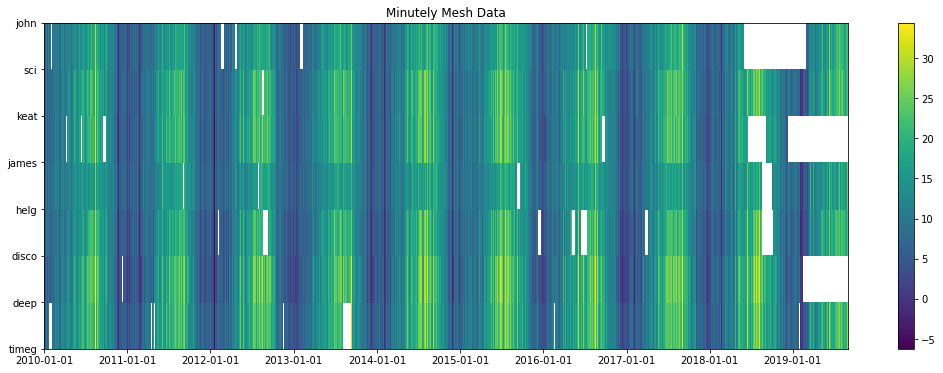

In [7]:
## Examining the data to see where there are 'holes' ##
#Will interpolate to fill them in later

tickmesh = ticks([2010,1,1],[2019,8,31],freq=True)

plt.figure(figsize=(18,6))
xmesh = tempm.timeg[3::2*1440]
ymesh = tempm.columns
plt.pcolormesh(xmesh,ymesh,matrix(tempm[3::2*1440]))
plt.title('Minutely Mesh Data')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

In [8]:
## Finding the firat and last dates ##
#In the hourly data

print("First" , dt.fromordinal(int(temph.timeg[0])))
print("Last" , dt.fromordinal(int(temph.timeg.iloc[-1])))

First 2008-01-01 00:00:00
Last 2019-08-31 00:00:00


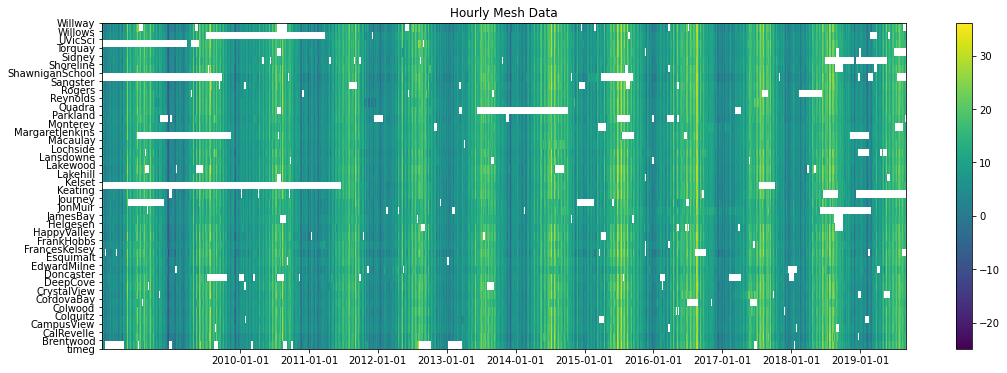

In [9]:
## Examining the data to see where there are 'holes' ##
#Will interpolate to fill them in later

tickmesh1 = ticks([2008,1,1],[2019,8,31],freq=True)

plt.figure(figsize=(18,6))
xmesh1 = temph.timeg
ymesh1 = temph.columns
plt.pcolormesh(xmesh1,ymesh1,matrix(temph))
plt.title('Hourly Mesh Data')
plt.xticks(ticks=tickmesh[1], labels=tickmesh[0])
# plt.xticklabels(tickmesh[0])
plt.colorbar()
plt.show()

In [50]:
## Interpolating blank spots in data ##
#Filling with cubic spline interpolation

def interp_nans(temp): #Takes in all temp data
    temps_new = copy.deepcopy(temp) #Copies temperature data to prevent overwriting
    data_new = []
    for data in temps_new: #data = array from each of the stations
        nanmask = np.isnan(data) #Creates mask of True = nan value, False = real value
        data[nanmask] = np.nanmean(temps_new.T[nanmask], axis=1) 
        #Replaces nan values with means in a given column across all stations
        data_new.append(data)
        
    return data_new


#Turn into a function
def min_interp_cubic(station_clean, time): #station_clean = no nans, time = minutes
    remove = np.where(np.isnan(station_clean)==True) #Finding locations where there are nans
    rm_mask = ~np.isnan(station_clean) #Creating a 'mask' of these nan values
    spline = scipy.interpolate.CubicSpline(time[rm_mask],station_clean[rm_mask])
    values = spline(time[remove])
    
    return (values,remove)#Turn into a function
    #values = clean data
    #

tempm_clean = interp_nans(np.array(tempm.drop(columns="timeg")).T) #Will be the 'cleaned' minutely temperature array
tempm_clean = np.array(tempm1) #Converted to array to use later

for station in tempm_clean:
    vals, rm = min_interp_cubic(station,np.array(tempm.timeg))
    station[rm] = vals

C:\Users\Rick\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [51]:
np.where(np.isnan(tempm_clean) == True) #Debugging shit
#Tells you if the interpolation worked properly

(array([], dtype=int64), array([], dtype=int64))

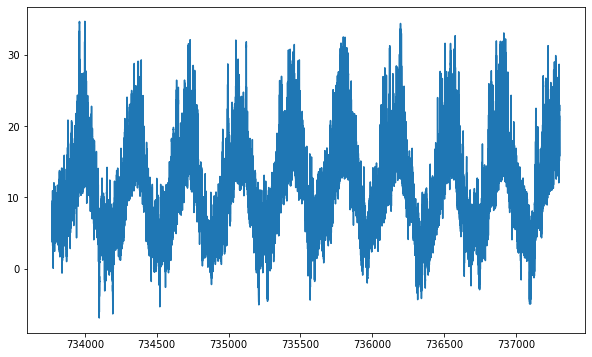

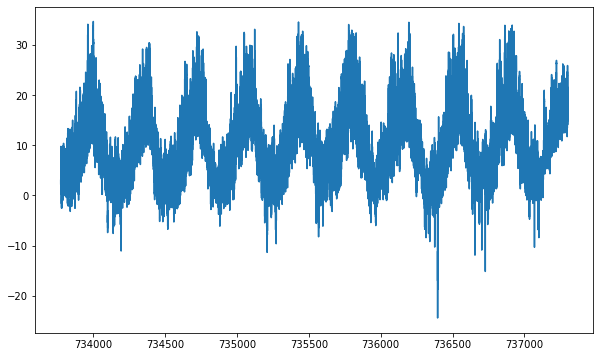

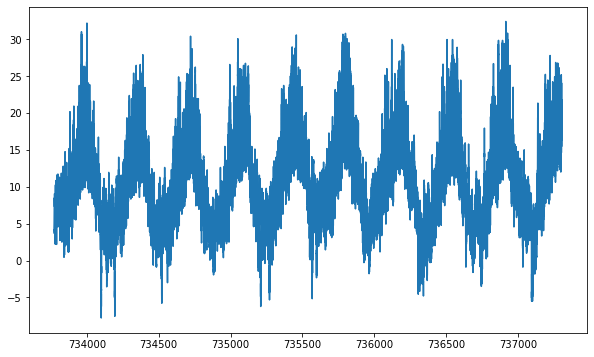

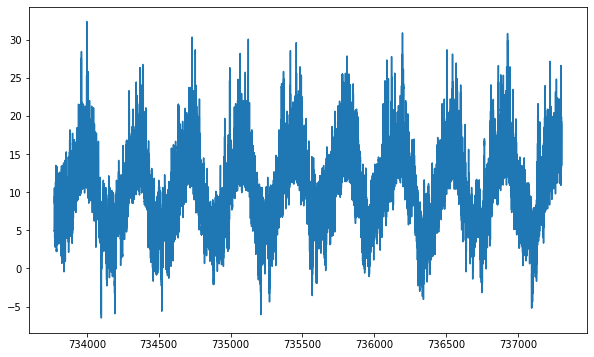

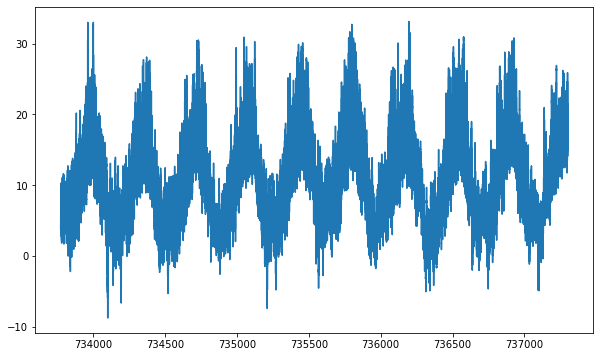

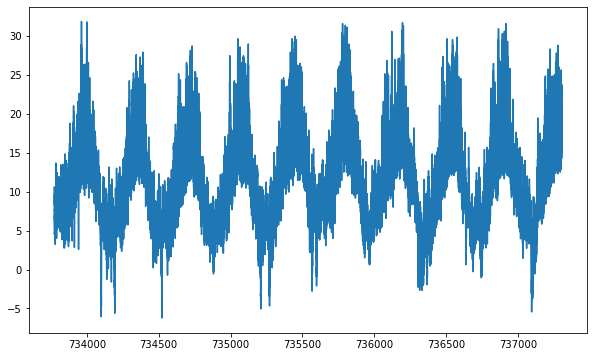

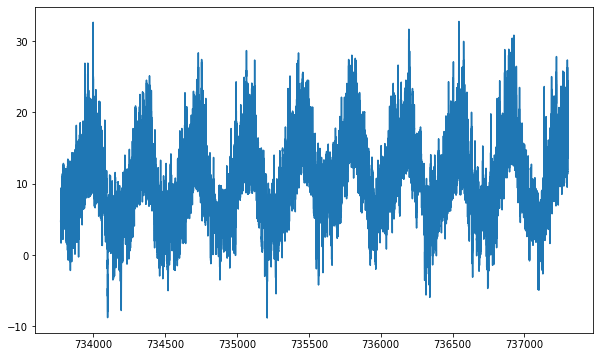

In [52]:
for i in range(len(tempm_clean)):
    plt.figure(figsize=(10,6))
    plt.plot(tempm.timeg,tempm_clean[i])
    plt.show()

In [56]:
## Converting back to a Pandas dataframe ##

tempm1 = pd.DataFrame(tempm_clean.T,columns=statm) #Use this from here
#Does NOT contain timeg! Have to use tempm.timeg to access time values

In [58]:
## For creating confidence intervals on the PSD plots ##

def conf_int(x):
    NFFT = 2**14
    n = int(len(x)/NFFT)
    num_seg = 2*n - 1
    nu = (4/3)*num_seg

    #95% CI
    alpha = 1 - 95/100
    chiu = stats.chi2.ppf(alpha/2,nu) #ppf gives inverse of chi^2 dist, chi_upper
    chil = stats.chi2.ppf(1-alpha/2,nu) #chi_lower
    erru = nu/chiu #Upper confidence limit
    errl = nu/chil #Lower limit
    
    return (errl,erru)

In [185]:
 ## Implementing 'the basics' to the minutely data ##
    
def gauss_pdf(x,mu,sigma):
    A = 1/(sigma*np.sqrt(2*np.pi))
    B = 0.5*((x-mu)/sigma)**2
    p = A*np.exp(-B)
    return p


def basic_plots(temp,name,col): #temp from a given station
    
    #Basic values
    mean = np.mean(temp)
    median = np.median(temp)
    std = np.std(temp)
    mintemp = np.min(temp)
    maxtemp = np.max(temp)
    fs = 1/60 #Sampling frequency
    NFFT = 2**14
    
    #Creating PSD
    Gamma = scipy.signal.welch(temp,fs,nperseg=NFFT) #PSD
    errl,erru = conf_int(temp) #Lower, upper CI for PSD
    
    
    plt.figure(figsize=(16, 10))
    plt.suptitle(name)
    plt.tight_layout()
    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    ax4 = plt.subplot(2,1,2)
    axes = [ax1, ax2, ax3, ax4]
    
    #Creating PDF
    ax1.hist(temp,bins=60,density=True,color=col,edgecolor='k') #Density = True, normalizes the PDF
    #Note that normalizing is ESSENTIAL for getting the Gaussian fit to work
    x = np.linspace(min(temp),max(temp),len(temp))
    label = 'Gaussian fit \n $\mu$ = {:.3f} \n $\sigma$ = {:.3f}'.format(mean,std)
    ax1.plot(x,gauss_pdf(x,mean,std),color='r',label=label)
    ax1.set_xlabel('Temperature (°C)')
    ax1.set_ylabel('Normalized Counts')
    ax1.set_title('Normalized PDF')
    ax1.legend(loc="upper right")
    
    
    ax2.loglog(Gamma[0],Gamma[1],color=col)
    ax2.fill_between(Gamma[0],Gamma[1]*errl,Gamma[1]*erru,alpha=0.5,color='m')
    ax2.set_title('PSD')
    ax2.set_xlabel('Frequency [cpd]')
    ax2.set_ylabel("$\Gamma$ [$°C^2$/Hz] ")
    
    ax3.semilogx(Gamma[0],Gamma[0]*Gamma[1],color=col)
    ax3.set_title('Variance-Preserving PSD')
    ax3.set_xlabel("Frequency [cpd]")
    ax3.set_ylabel(r"f·$\Gamma(f)$ [$°C^2$]")
    
    #Time Series
    tick = ticks([2010,1,1],[2019,8,31],freq=True)
    ax4.plot(tempm.timeg,temp,color=col)
    ax4.set_title('Time Series')
    ax4.set_xticks(tick[1])
    ax4.set_xticklabels(tick[0])
    ax4.set_ylabel('Temperature [°C]')
    ax4.set_xlabel('Time [date]')
    
    plt.savefig("Basics_"+name+".png")
    
    
    print("Mean temperature: %.3f" % mean , "°C")
    print("Standard deviation in temperature: %.3f" % std , "°C")
    print()

Mean temperature: 10.956 °C
Standard deviation in temperature: 6.176 °C

Mean temperature: 9.943 °C
Standard deviation in temperature: 7.149 °C

Mean temperature: 10.296 °C
Standard deviation in temperature: 5.705 °C

Mean temperature: 10.213 °C
Standard deviation in temperature: 4.615 °C

Mean temperature: 10.649 °C
Standard deviation in temperature: 5.941 °C

Mean temperature: 11.181 °C
Standard deviation in temperature: 5.544 °C

Mean temperature: 10.174 °C
Standard deviation in temperature: 5.065 °C



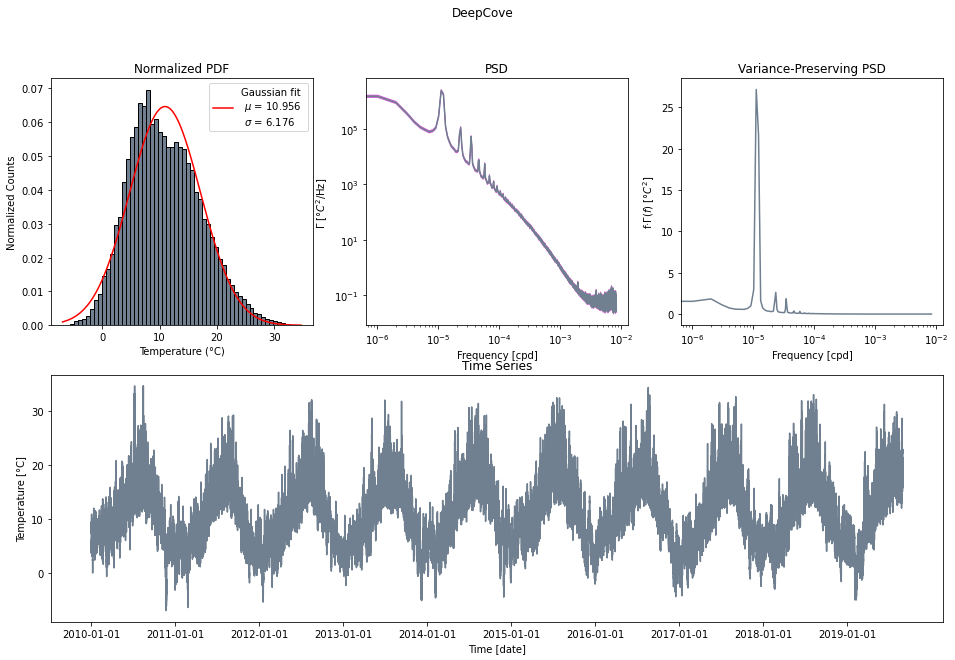

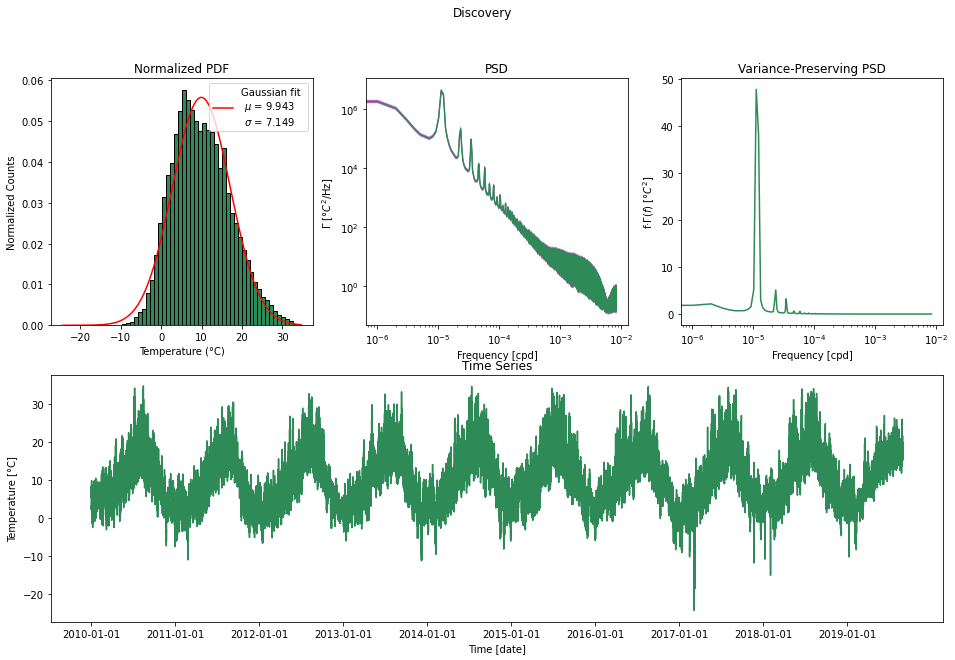

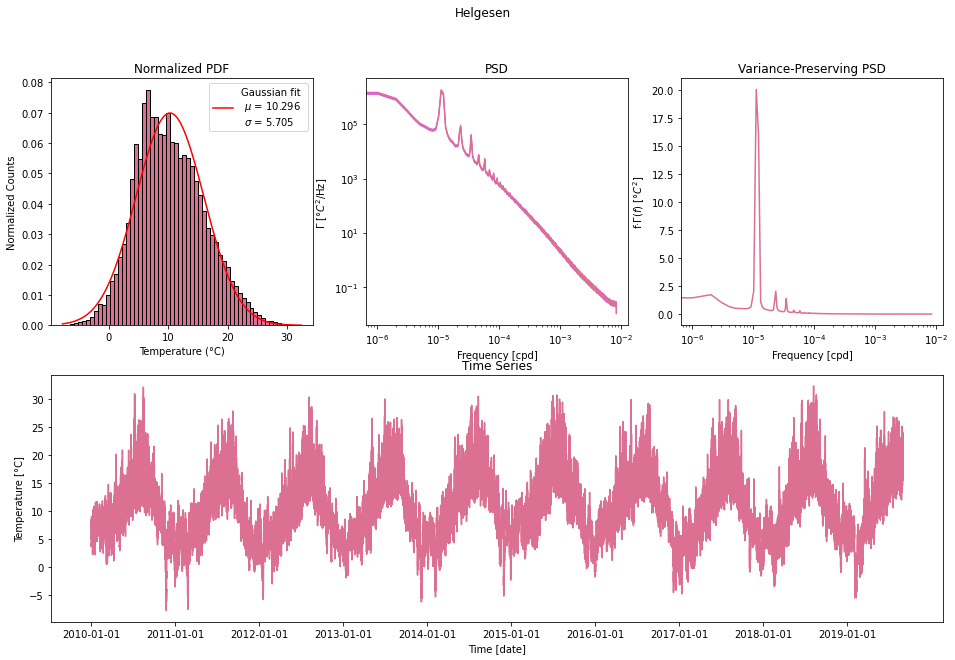

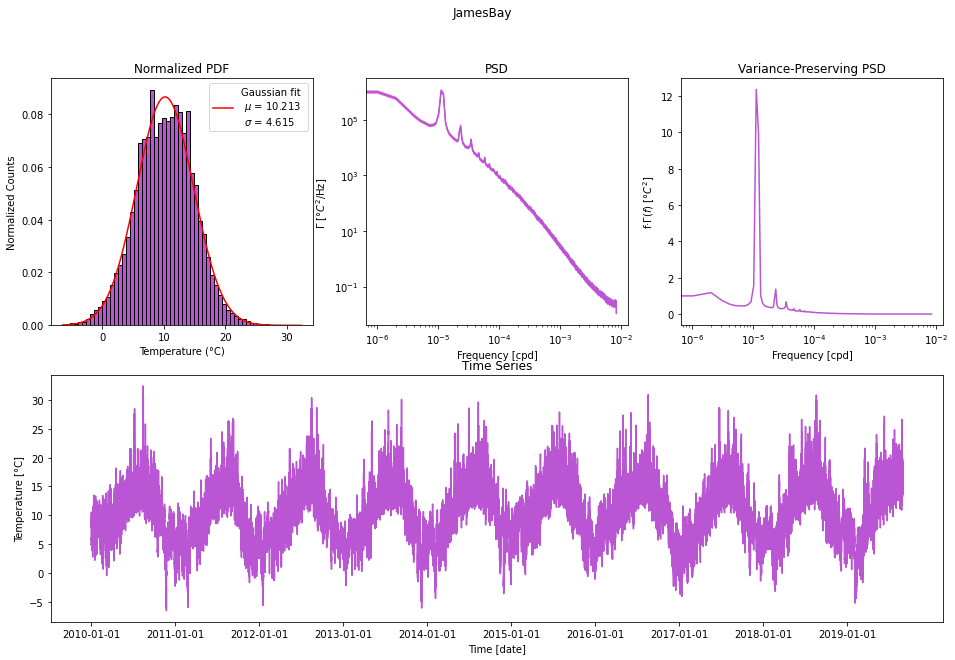

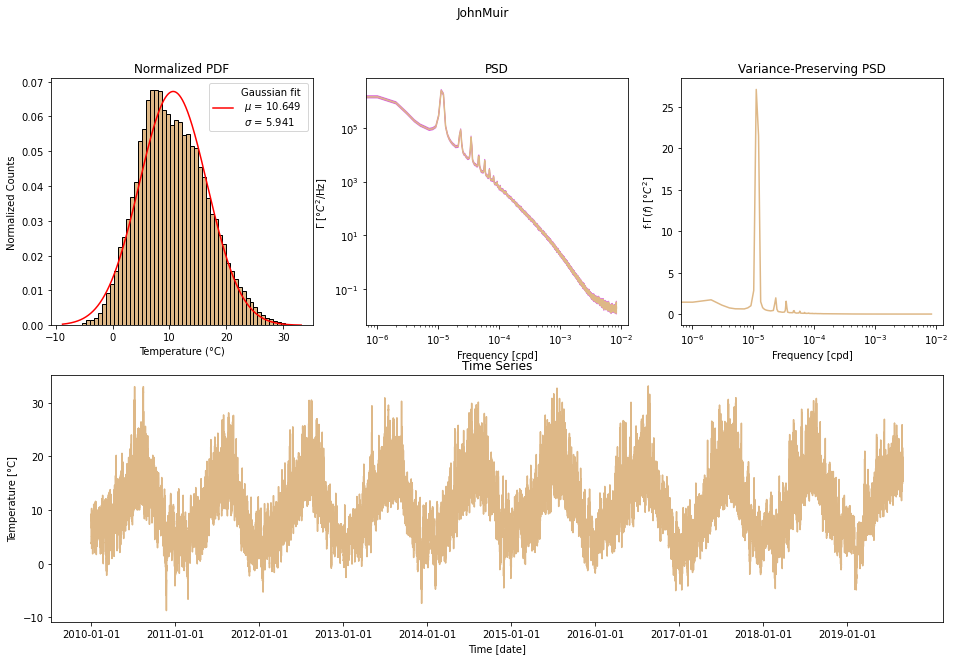

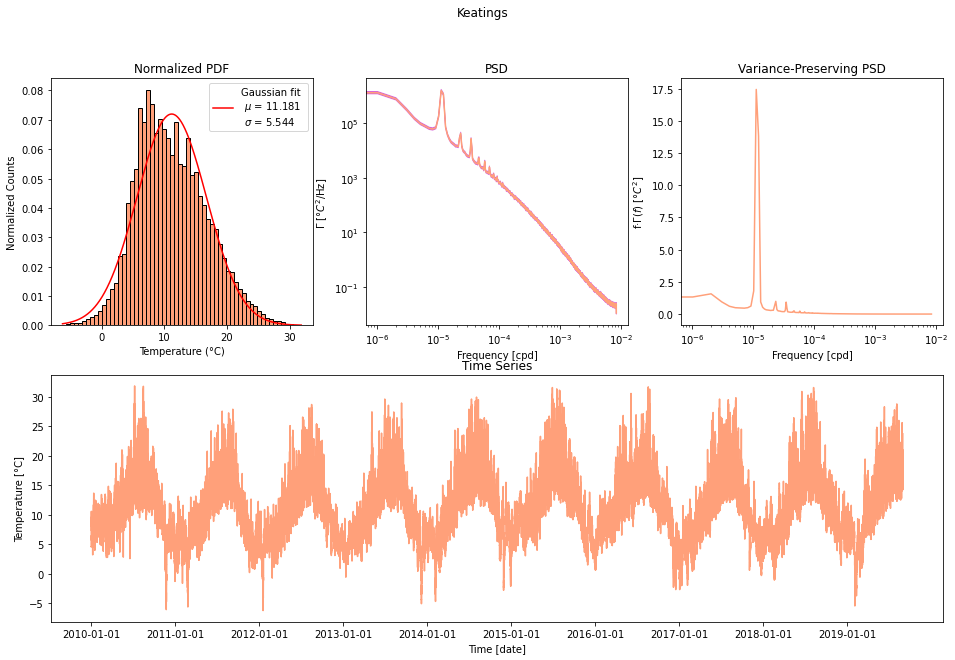

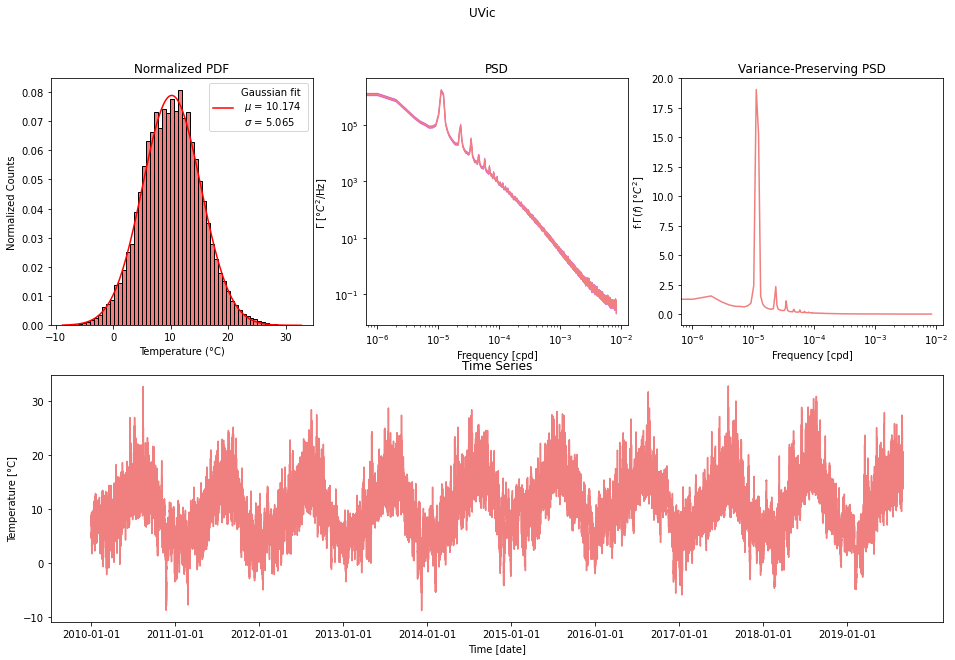

In [187]:
# basic_plots(tempm1['DeepCove'],'DeepCove','slategray')

##KEEP
plot_colors = ['slategray','seagreen','palevioletred','mediumorchid','burlywood','lightsalmon','lightcoral']

for station,color in zip(statm,plot_colors):
    basic_plots(tempm1[station],station,color)

In [ ]:
## Find cross-correlations between stations ##



In [ ]:
# ## Cutting the data into time segments ##
# #i) data from June 1-September 30 2017
# #ii) data from November 1 2018-February 28 2019

# left1 = dt.toordinal(dt(2017,6,1))
# right1 = dt.toordinal(dt(2017,10,1)) #Summer

# left2 = dt.toordinal(dt(2018,11,1))
# right2 = dt.toordinal(dt(2019,3,1)) #Winter


# #Part i)
# #James Bay
# tempo_var_james = tm_df_james[tm_df_james.time >= left1]
# ts1_james = tempo_var_james[tempo_var_james.time < right1] #time segment 1 (summer), James Bay
# #Part ii)
# tempo_var_james = tm_df_james[tm_df_james.time >= left2]
# ts2_james = tempo_var_james[tempo_var_james.time < right2] #Winter

In [ ]:
# startDatewinter = pd.Timestamp(2017, 11, 1)
# endDatewinter   = pd.Timestamp(2018, 2, 28)

# startDatesummer = pd.Timestamp(2017, 6, 1)
# endDatesummer   = pd.Timestamp(2017, 9, 30)

# winterdc = searchDate(dc,startDatewinter, endDatewinter)
# summerdc = searchDate(dc,startDatesummer,endDatesummer)

# winterjb = searchDate(jb,startDatewinter,endDatewinter)
# summerjb = searchDate(jb, startDatesummer,endDatesummer)

# winterde = searchDate(de,startDatewinter,endDatewinter)
# summerde = searchDate(de, startDatesummer,endDatesummer)

# winterhe = searchDate(he,startDatewinter,endDatewinter)
# summerhe = searchDate(he, startDatesummer,endDatesummer)

# winterke = searchDate(ke,startDatewinter,endDatewinter)
# summerke = searchDate(ke, startDatesummer,endDatesummer)

# winterus = searchDate(us,startDatewinter,endDatewinter)
# summerus = searchDate(us, startDatesummer,endDatesummer)

# winterjm = searchDate(jm,startDatewinter,endDatewinter)
# summerjm = searchDate(jm, startDatesummer,endDatesummer)